In [1]:
import nltk
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from wordcloud import WordCloud

import pandas as pd
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import seaborn as sbn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC

from keras import models
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM, Embedding

path = '/Users/yadushyadav/Downloads/imdb/'

/Users/yadushyadav/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def shuffle(X, y):
    perm = np.random.permutation(len(X))
    X = X[perm]
    y = y[perm]
    return X, y

In [3]:
def load_imdb_dataset(path):
    imdb_path = path
    train_texts = []
    train_labels = []
    test_texts = []
    test_labels = []
    for dset in ['train', 'test']:
        for cat in ['pos', 'neg']:
            dset_path = os.path.join(imdb_path, dset, cat)
            for fname in sorted(os.listdir(dset_path)):
                if fname.endswith('.txt'):
                    with open(os.path.join(dset_path, fname)) as f:
                        if dset == 'train': train_texts.append(f.read())
                        else: test_texts.append(f.read())
                    label = 0 if cat == 'neg' else 1
                    if dset == 'train': train_labels.append(label)
                    else: test_labels.append(label)

    train_texts = np.array(train_texts)
    train_labels = np.array(train_labels)
    test_texts = np.array(test_texts)
    test_labels = np.array(test_labels)

    train_texts, train_labels = shuffle(train_texts, train_labels)
    test_texts, test_labels = shuffle(test_texts, test_labels)

    return train_texts, train_labels, test_texts, test_labels

In [4]:
# Loading the dataset
xtrain, ytrain, xtest, ytest = load_imdb_dataset(path)

In [5]:
# Creating a dataframe

df = pd.DataFrame()

df['review'] = xtrain
df['label'] = ytrain

In [6]:
df.head()

,review,label
0,This wilfully bizarre adaptation of Borges sho...,0
1,This movie was just as good as some of the oth...,1
2,In all of low budget history. this movie has t...,0
3,Memoirs of a Geisha is a beautifully filmed mo...,0
4,The movie takes place in a little Swedish town...,1


In [7]:
df.shape

(25000, 2)

In [8]:
# Removing special characters

df['review'] = df['review'].str.replace("[^a-zA-Z]", " ")

In [9]:
# Removing small words

def removesmall(x):
    v = []
    for i in x.split():
        if len(i)>2:
            v.append(i)
            #v.append(' ')
    return ' '.join([k for k in v])

df['long_review'] = df['review'].apply(lambda x: removesmall(x))

In [10]:
df.head()

,review,label,long_review
0,This wilfully bizarre adaptation of Borges sho...,0,This wilfully bizarre adaptation Borges short ...
1,This movie was just as good as some of the oth...,1,This movie was just good some the other wester...
2,In all of low budget history this movie has t...,0,all low budget history this movie has one the ...
3,Memoirs of a Geisha is a beautifully filmed mo...,0,Memoirs Geisha beautifully filmed movie there ...
4,The movie takes place in a little Swedish town...,1,The movie takes place little Swedish town wher...


In [11]:
# Tokenization

df['tokenized_review'] = df['long_review'].apply(lambda x: x.split())

df.head()

,review,label,long_review,tokenized_review
0,This wilfully bizarre adaptation of Borges sho...,0,This wilfully bizarre adaptation Borges short ...,"[This, wilfully, bizarre, adaptation, Borges, ..."
1,This movie was just as good as some of the oth...,1,This movie was just good some the other wester...,"[This, movie, was, just, good, some, the, othe..."
2,In all of low budget history this movie has t...,0,all low budget history this movie has one the ...,"[all, low, budget, history, this, movie, has, ..."
3,Memoirs of a Geisha is a beautifully filmed mo...,0,Memoirs Geisha beautifully filmed movie there ...,"[Memoirs, Geisha, beautifully, filmed, movie, ..."
4,The movie takes place in a little Swedish town...,1,The movie takes place little Swedish town wher...,"[The, movie, takes, place, little, Swedish, to..."


In [12]:
# Lancaster Stemming

stem = LancasterStemmer()

def lstemtweet(x):
    v = []
    for i in x:
        v.append(stem.stem(i))
    return ' '.join([k for k in v])

df['lancasterstemmed_review'] = df['tokenized_review'].apply(lambda x: lstemtweet(x))

In [13]:
# Porter Stemming

stem = PorterStemmer()

def pstemtweet(x):
    v = []
    for i in x:
        v.append(stem.stem(i))
    return ' '.join([k for k in v])

df['porterstemmed_review'] = df['tokenized_review'].apply(lambda x: pstemtweet(x))

df.head()

,review,label,long_review,tokenized_review,lancasterstemmed_review,porterstemmed_review
0,This wilfully bizarre adaptation of Borges sho...,0,This wilfully bizarre adaptation Borges short ...,"[This, wilfully, bizarre, adaptation, Borges, ...",thi wil bizar adapt borg short story typ cox h...,thi wil bizarr adapt borg short stori typic co...
1,This movie was just as good as some of the oth...,1,This movie was just good some the other wester...,"[This, movie, was, just, good, some, the, othe...",thi movy was just good som the oth western mad...,thi movi wa just good some the other western m...
2,In all of low budget history this movie has t...,0,all low budget history this movie has one the ...,"[all, low, budget, history, this, movie, has, ...",al low budget hist thi movy has on the worst t...,all low budget histori thi movi ha one the wor...
3,Memoirs of a Geisha is a beautifully filmed mo...,0,Memoirs Geisha beautifully filmed movie there ...,"[Memoirs, Geisha, beautifully, filmed, movie, ...",memoir geish beauty film movy ther doubt about...,memoir geisha beauti film movi there doubt abo...
4,The movie takes place in a little Swedish town...,1,The movie takes place little Swedish town wher...,"[The, movie, takes, place, little, Swedish, to...",the movy tak plac littl swed town wher everybo...,the movi take place littl swedish town where e...


Lancaster Stemmer is more aggressive compared to the Porter Stemmer

In [14]:
# Lemmatizing
#nltk.download('wordnet')

lemm = WordNetLemmatizer()
    
def lemmatizetweet(x):
    v = []
    for i in x:
        v.append(lemm.lemmatize(i))
    return ' '.join([k for k in v])

df['lemmatized_review'] = df['tokenized_review'].apply(lambda x: lemmatizetweet(x))

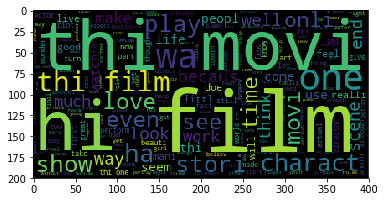

In [15]:
# Common words in positive reviews

words1 = ' '.join([x for x in df['porterstemmed_review'][df['label']==1]])

wc1 = WordCloud().generate(words1)

plt.imshow(wc1)
plt.show()

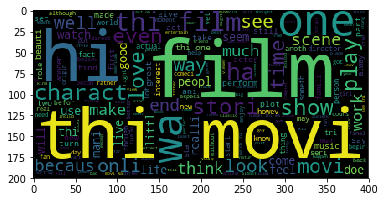

In [16]:
# Common words in negative reviews

words2 = ' '.join([x for x in df['porterstemmed_review'][df['label']==1]])

wc2 = WordCloud().generate(words2)

plt.imshow(wc2)
plt.show()

WordCloud was not useful to find common words in this case 

In [17]:
# TF-IDF vectorizing

tfidf_vectorizer = TfidfVectorizer(stop_words='english')

tfidf1 = tfidf_vectorizer.fit_transform(df['porterstemmed_review'])
tfidf2 = tfidf_vectorizer.fit_transform(df['lancasterstemmed_review'])
tfidf3 = tfidf_vectorizer.fit_transform(df['lemmatized_review'])

In [18]:
type(tfidf1)

scipy.sparse.csr.csr_matrix

In [19]:
# 80-20 train-test split

xtrain1 = tfidf1[:20000,:]
ytrain1 = df['label'].iloc[:20000]
xtest1 = tfidf1[20000:,:]
ytest1 = df['label'].iloc[20000:]

xtrain2 = tfidf2[:20000,:]
ytrain2 = df['label'].iloc[:20000]
xtest2 = tfidf2[20000:,:]
ytest2 = df['label'].iloc[20000:]

xtrain3 = tfidf3[:20000,:]
ytrain3 = df['label'].iloc[:20000]
xtest3 = tfidf3[20000:,:]
ytest3 = df['label'].iloc[20000:]

In [20]:
model = BernoulliNB()
model.fit(xtrain1,ytrain1)
pred = model.predict(xtest1)
print("Porter Stemming: ",roc_auc_score(pred,ytest1))

model.fit(xtrain2,ytrain2)
pred = model.predict(xtest2)
print("Lancaster Stemming: ",roc_auc_score(pred,ytest2))

model.fit(xtrain3,ytrain3)
pred = model.predict(xtest3)
print("Lemmatization: ",roc_auc_score(pred,ytest3))

Porter Stemming:  0.8357661769945217
Lancaster Stemming:  0.830970361685181
Lemmatization:  0.8348196262172557


In [21]:
model = MultinomialNB()
model.fit(xtrain1,ytrain1)
pred = model.predict(xtest1)
print("Porter Stemming: ",roc_auc_score(pred,ytest1))

model.fit(xtrain2,ytrain2)
pred = model.predict(xtest2)
print("Lancaster Stemming: ",roc_auc_score(pred,ytest2))

model.fit(xtrain3,ytrain3)
pred = model.predict(xtest3)
print("Lemmatization: ",roc_auc_score(pred,ytest3))

Porter Stemming:  0.8424377511969384
Lancaster Stemming:  0.8364834390415785
Lemmatization:  0.8475936936296592


In [22]:
model = LogisticRegression(penalty='l2')
model.fit(xtrain1,ytrain1)
pred = model.predict(xtest1)
print("Porter Stemming: ",roc_auc_score(pred,ytest1))

model = LogisticRegression(penalty='l2')
model.fit(xtrain2,ytrain2)
pred = model.predict(xtest2)
print("Lancaster Stemming: ",roc_auc_score(pred,ytest2))

model = LogisticRegression(penalty='l2')
model.fit(xtrain3,ytrain3)
pred = model.predict(xtest3)
print("Lemmatization: ",roc_auc_score(pred,ytest3))

Porter Stemming:  0.8577017624309136
Lancaster Stemming:  0.8504746278521093
Lemmatization:  0.8532320035003718


In [23]:
model = DecisionTreeClassifier()
model.fit(xtrain1,ytrain1)
pred = model.predict(xtest1)
print("Porter Stemming: ",roc_auc_score(pred,ytest1))

model.fit(xtrain2,ytrain2)
pred = model.predict(xtest2)
print("Lancaster Stemming: ",roc_auc_score(pred,ytest2))

model.fit(xtrain3,ytrain3)
pred = model.predict(xtest3)
print("Lemmatization: ",roc_auc_score(pred,ytest3))

Porter Stemming:  0.7122252286804274
Lancaster Stemming:  0.7014150190937496
Lemmatization:  0.7266000831413671


In [24]:
model = KNeighborsClassifier()
model.fit(xtrain1,ytrain1)
pred = model.predict(xtest1)
print("Porter Stemming: ",roc_auc_score(pred,ytest1))

model.fit(xtrain2,ytrain2)
pred = model.predict(xtest2)
print("Lancaster Stemming: ",roc_auc_score(pred,ytest2))

model.fit(xtrain3,ytrain3)
pred = model.predict(xtest3)
print("Lemmatization: ",roc_auc_score(pred,ytest3))

Porter Stemming:  0.7990900204999292
Lancaster Stemming:  0.7974468997513168
Lemmatization:  0.7935942056982314


In [25]:
model = RandomForestClassifier()
model.fit(xtrain1,ytrain1)
pred = model.predict(xtest1)
print("Porter Stemming: ",roc_auc_score(pred,ytest1))

model.fit(xtrain2,ytrain2)
pred = model.predict(xtest2)
print("Lancaster Stemming: ",roc_auc_score(pred,ytest2))

model.fit(xtrain3,ytrain3)
pred = model.predict(xtest3)
print("Lemmatization: ",roc_auc_score(pred,ytest3))

Porter Stemming:  0.76254230513683
Lancaster Stemming:  0.7482387032994927
Lemmatization:  0.7726178151774378


In [ ]:
model = models.Sequential()

model.add(Embedding(20000, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(xtrain1, ytrain1, batch_size=1, epochs=2, validation_data=(xtest1, ytest1))

In [27]:
model = LogisticRegression(penalty='l2')
model.fit(xtrain1,ytrain1)
predictions = model.predict(tfidf1[20000:])


print("Rating of the movie is: ", np.count_nonzero(predictions==1)/500, "/10")

Rating of the movie is:  5.144 /10
